In [1]:
from neurhci.uhci import UHCI
from neurhci.hierarchical import HCI

from neurhci.marginal_utilities import *
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

This file contains an example on how to build, train, and explain a model.

# Model Creation

We first define a hierarchy as a dict {id of the parents: [ids of the children]}. All ids are integer.

In [2]:
hierarchy = {-1:[0,1,2,5], 5:[3,4]} 

This corresponds to a tree with:
* root -1 (since it has no parent)
* leaves 0,1,2,3 and 4 (since they have no child).
* 5 is an intermediate node, which aggregates 3 and 4.
* The root -1 aggregates leaves 0,1,2 and 5.

We build our UHCI model with the hierarchy provided. 
We precise that leaf 0 has a non-decreasing marginal utility, and leaf 2 has a non-increasing one.
Leaves 1, 3 and 4 will have no marginal utility (i.e. an Indentity).

The marginal utilities each have 15 sigmoids (i.e. hidden neurons).

In [3]:
model = UHCI(hierarchy=hierarchy, types_of_leaves={0:NonDecreasing, 2:NonIncreasing}, nb_sigmoids=15)

If one already has a pre-trained HCI and/or MarginalUtilitiesLayer, they can be used to initialize the model.

Any coherent combination of the different types of inputs works. For instance, the different lines below all create a similar model:

In [7]:
hci = HCI(hierarchy) # can be pretrained
marginal_utilities = MarginalUtilitiesLayer(list_of_leaves=[0,1,2,3,4], types_of_leaves={0:NonDecreasing, 2:NonIncreasing}, nb_sigmoids=15)

model2 = UHCI(hci=hci, types_of_leaves={0:NonDecreasing, 2:NonIncreasing}, nb_sigmoids=15)
model3 = UHCI(hci=hci, marginal_utilities=marginal_utilities)
model4 = UHCI(hierarchy=hierarchy, marginal_utilities=marginal_utilities)


# Synthetic Data

Below, we initialize some data for our model to train from. We show that the model used to generate the data is recovered by the trained model.

The ground truth model is a HCI with same hierarchy as model, but described explicitely to avoid any ambiguity.

Its marginal utilities are $u_0(x_0)=x_0**3$ and $u_2(x_2) = 1-x^2$. $u_1$, $u_3$ and $u_4$ are all identities.

The aggregation corresponds to the following function:
* at the intermediate node 5: $u_5 = 0.4 u_3 + 0.1 u_4 + 0.5 min(u_3, u_4)$
* at the root -1: $u_{-1} = 0.2 u_0 + 0.3 u_2 + 0.2 u_5 + 0.2 min(u_0, u_5) + 0.1 max(u_1, u_2)$

In [8]:
def ground_truth_model(data):
    #applying marginal utilities:
    data_after_utilities = data.clone()
    data_after_utilities[:,0] = data_after_utilities[:,0]**3
    data_after_utilities[:,2] = 1-data_after_utilities[:,2]**2
    
    #aggregating at node 5:
    u5 = 0.4*data_after_utilities[:,3] + 0.1*data_after_utilities[:,4]
    u5 += torch.min(data_after_utilities[:,(3,4)], axis=1).values*0.5

    #aggregating at node -1
    gtd = 0.2*data_after_utilities[:,0] + 0.3*data_after_utilities[:,2] + 0.2*u5
    gtd += torch.min(torch.cat((data_after_utilities[:, 0:1], u5.unsqueeze(1)), axis=-1), axis=1).values*0.2
    gtd += torch.max(data_after_utilities[:, (1,2)], axis=1).values*0.1
    gtd = gtd.unsqueeze(1)
    return(data_after_utilities, gtd)

data_train = torch.rand((200,5)) #draw random data for training ; since the model is (very) small, we do not need a lot.
data_test = torch.rand((1000,5)) #draw random data for testing

train_after_utilities, labels_train = ground_truth_model(data_train) #compute the ground-truth labels for training data
test_after_utilities, labels_test = ground_truth_model(data_test) #compute the ground-truth labels for testing data

# Training

We now train our model with a basic torch loop:

In [9]:
optimizer = optim.Adam(model.parameters(), lr=0.02) # can be tuned for better results
criterion = nn.MSELoss()

for epoch in range(2000):
    optimizer.zero_grad()
    pred = model(data_train)
    training_loss = criterion(pred, labels_train)
    training_loss.backward(retain_graph=True)
    optimizer.step()
    if not epoch%100:
        with torch.no_grad():
            pred_test = model(data_test)
            testing_loss = criterion(pred_test, labels_test)
        print(f'Epoch {epoch}, training loss {training_loss}, testing loss {testing_loss}')
with torch.no_grad():
    pred_train = model(data_train)
    training_loss = criterion(pred_train, labels_train)
    pred_test = model(data_test)
    testing_loss = criterion(pred_test, labels_test)
print(f'Final training loss {training_loss}, Final testing loss {testing_loss}')

Epoch 0, training loss 0.020550929009914398, testing loss 0.019231460988521576
Epoch 100, training loss 0.0011395454639568925, testing loss 0.0015538526931777596
Epoch 200, training loss 0.0003090241807512939, testing loss 0.00043608364649116993
Epoch 300, training loss 0.0001621447881916538, testing loss 0.00023180237622000277
Epoch 400, training loss 0.00011743599316105247, testing loss 0.00016877292364370078
Epoch 500, training loss 8.194996189558879e-05, testing loss 0.00012271350715309381
Epoch 600, training loss 4.858566899201833e-05, testing loss 7.892934081610292e-05
Epoch 700, training loss 3.297368675703183e-05, testing loss 5.482136839418672e-05
Epoch 800, training loss 2.4284503524540924e-05, testing loss 4.039486884721555e-05
Epoch 900, training loss 1.898499067465309e-05, testing loss 3.195790486643091e-05
Epoch 1000, training loss 1.5403615179820918e-05, testing loss 2.6403524316265248e-05
Epoch 1100, training loss 1.28431183838984e-05, testing loss 2.2429943783208728e-0

# Plotting the marginal utilities

We plot the marginal utilities and compare them to the ground truth functions:

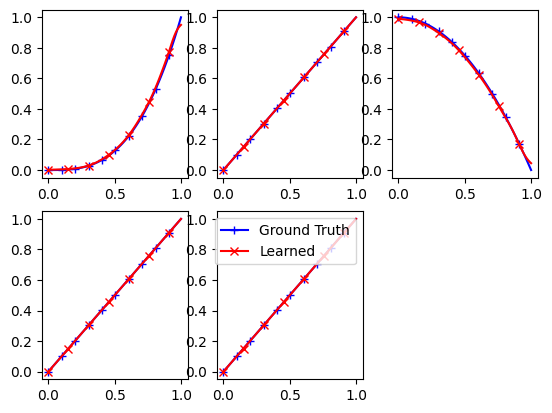

In [10]:
x = torch.linspace(0,1,100).unsqueeze(1)
gt_utilities = {0:lambda x:x**3, 2:lambda x:1-x*x}
for i in range(5):
    plt.subplot(2,3,i+1)
    ground_truth = lambda x:x
    if i in gt_utilities:
        ground_truth = gt_utilities[i]
    plt.plot(x.detach().numpy(), ground_truth(x).detach().numpy(), color='blue', marker='+', markevery=10, label='Ground Truth')
    plt.plot(x.detach().numpy(), model.marginal_utilities[i](x).detach().numpy(), color='red', marker='x', markevery=15, label="Learned")
plt.legend()

# Analyzing the aggregators

We can check that the weights fit the ground truth's.

Recall that: $u_5 = 0.4 u_3 + 0.1 u_4 + 0.5 min(u_3, u_4)$

The weights are ordered such that (with n the size of the aggregator):
    * the nodes from 0 to n-1 weights correspond to the n leaves, in order
    * the nodes from n to n(n+1)/2-1 correspond to the min between pairs, with pairs
        following the lexicographic ordering: (0,1),(0,2),(...),(0,n),(1,2),(1,3)...,(n-1,n)
    * the nodes from n(n+1)/2 to n**2-1 correspond to max between pairs, ordered in the same way

We thus expect the weight vector for u5 to be:
[0.4, 0.1, 0.5, 0.]

Since these weights are not identifiable, we need to compute their (unique) equivalent canonical form (see thesis).

Note that the aggregators are accessed through the string version of their identifier (imposed by the nn.ModuleDict class).

In [16]:
cweights5 = model.HCI.CIs['5'].canonical_weights()

print("For aggregator 5:")
print(f"Weight for u3          - ground truth 0.4 - learned value {cweights5[0,0]}")
print(f"Weight for u4          - ground truth 0.1 - learned value {cweights5[0,1]}")
print(f"Weight for min(u3, u4) - ground truth 0.5 - learned value {cweights5[0,2]}")
print(f"Weight for max(u3, u4) - ground truth 0.0 - learned value {cweights5[0,3]}")

For aggregator 5:
Weight for u3          - ground truth 0.4 - learned value 0.404276967048645
Weight for u4          - ground truth 0.1 - learned value 0.10136852413415909
Weight for min(u3, u4) - ground truth 0.5 - learned value 0.4943544864654541
Weight for max(u3, u4) - ground truth 0.0 - learned value 0.0


In the same way, recall that:
$u_{-1} = 0.2 u_0 + 0.3 u_2 + 0.2 u_5 + 0.2 min(u_0, u_5) + 0.1 max(u_1, u_2)$ 

In [17]:
cweightsm1 = model.HCI.CIs['-1'].canonical_weights()

print("For aggregator -1:")
print(f"Weight for u0          - ground truth 0.2 - learned value {cweightsm1[0,0]}")
print(f"Weight for u1          - ground truth 0.0 - learned value {cweightsm1[0,1]}")
print(f"Weight for u2          - ground truth 0.3 - learned value {cweightsm1[0,2]}")
print(f"Weight for u5          - ground truth 0.2 - learned value {cweightsm1[0,3]}")
print(f"Weight for min(u0, u1) - ground truth 0.0 - learned value {cweightsm1[0,4]}")
print(f"Weight for min(u0, u2) - ground truth 0.0 - learned value {cweightsm1[0,5]}")
print(f"Weight for min(u0, u5) - ground truth 0.2 - learned value {cweightsm1[0,6]}")
print(f"Weight for min(u1, u2) - ground truth 0.0 - learned value {cweightsm1[0,7]}")
print(f"Weight for min(u1, x5) - ground truth 0.0 - learned value {cweightsm1[0,8]}")
print(f"Weight for min(u2, x5) - ground truth 0.0 - learned value {cweightsm1[0,9]}")
print(f"Weight for max(u0, x1) - ground truth 0.0 - learned value {cweightsm1[0,10]}")
print(f"Weight for max(u0, x2) - ground truth 0.0 - learned value {cweightsm1[0,11]}")
print(f"Weight for max(u0, x5) - ground truth 0.0 - learned value {cweightsm1[0,12]}")
print(f"Weight for max(u1, x2) - ground truth 0.1 - learned value {cweightsm1[0,13]}")
print(f"Weight for max(u1, x5) - ground truth 0.0 - learned value {cweightsm1[0,14]}")
print(f"Weight for max(u2, x5) - ground truth 0.0 - learned value {cweightsm1[0,15]}")

For aggregator -1:
Weight for u0          - ground truth 0.2 - learned value 0.19353842735290527
Weight for u1          - ground truth 0.0 - learned value 0.005913214758038521
Weight for u2          - ground truth 0.3 - learned value 0.3131296932697296
Weight for u5          - ground truth 0.2 - learned value 0.19605407118797302
Weight for min(u0, u1) - ground truth 0.0 - learned value 0.0
Weight for min(u0, u2) - ground truth 0.0 - learned value 0.0028000585734844208
Weight for min(u0, u5) - ground truth 0.2 - learned value 0.1967405378818512
Weight for min(u1, u2) - ground truth 0.0 - learned value 0.0
Weight for min(u1, x5) - ground truth 0.0 - learned value 0.0
Weight for min(u2, x5) - ground truth 0.0 - learned value 0.0028149038553237915
Weight for max(u0, x1) - ground truth 0.0 - learned value 0.0006501071620732546
Weight for max(u0, x2) - ground truth 0.0 - learned value 0.0
Weight for max(u0, x5) - ground truth 0.0 - learned value 0.0
Weight for max(u1, x2) - ground truth 0.1 

# Computing the Möbius transforms

The Mobius transform of the parameters of a given aggregator can be obtained through the mobius() method.
The ordering is the same as above: first the n singletons, then the n(n-1)/2 pairs in lexicographic order.

In [15]:
mob5 = model.HCI.CIs['5'].mobius()
print(f"""Möbius values for aggregator 5: {mob5}.
      The synergy between 3 and 4 is observed by the positive value
        of the term corresponding to their min: {mob5[-1]}.
      """)

mobm1 = model.HCI.CIs['-1'].mobius()
print(f"""Möbius values for aggregator -1: 
      {mobm1}.
    The synergy between 0 and 5 is observed by the positive value
        of the term corresponding to their pair: {mobm1[6]}.
    The redundancy between 1 and 2 is observed by the negative value
        of the term corresponding to their pair: {mobm1[7]}.
    """)

Möbius values for aggregator 5: tensor([0.4043, 0.1014, 0.4944]).
      The synergy between 3 and 4 is observed by the positive value
        of the term corresponding to their min: 0.4943544864654541.
      
Möbius values for aggregator -1: 
      tensor([ 0.1942,  0.0949,  0.3980,  0.1995, -0.0007,  0.0028,  0.1967, -0.0849,
        -0.0035,  0.0028]).
    The synergy between 0 and 5 is observed by the positive value
        of the term corresponding to their pair: 0.1967405378818512.
    The redundancy between 1 and 2 is observed by the negative value
        of the term corresponding to their pair: -0.08488164097070694.
    


# Explanations at node level (Shapley values)

Finally, we show how to obtain the importance indices for the nodes (i.e. Shapley and Winter values), in both a global and an instance-wise context.

The global Shapley values give us the average local relative contribution of each child of a given aggregator wrt the value of said aggregator.

In [18]:
shap5 = model.HCI.CIs['5'].shapley_values_global()
print("Children of 5 and their global Shapley values wrt 5:")
for c,s in zip(model.HCI.hierarchy[5], shap5):
    print(f"{c} has a relative global influence of {s}")
print()
shapm1 = model.HCI.CIs['-1'].shapley_values_global()
print("Children of -1 and their global Shapley values wrt -1:")
for c,s in zip(model.HCI.hierarchy[-1], shapm1):
    print(f"{c} has a relative global influence of {s}")

Children of 5 and their global Shapley values wrt 5:
3 has a relative global influence of 0.6514542102813721
4 has a relative global influence of 0.34854578971862793

Children of -1 and their global Shapley values wrt -1:
0 has a relative global influence of 0.29363375902175903
1 has a relative global influence of 0.050417762249708176
2 has a relative global influence of 0.35837799310684204
5 has a relative global influence of 0.29757046699523926


# Explanation at model level (Winter values)

To obtain the global influence of a leaf wrt the root (or, if needed, of any node wrt to any of its ancestors), we compute the global Winter value (i.e. the generalization of the global Shapley values to a structured model).

Note that the model induced by the descendents of the ancestor node MUST be a tree.

In [19]:
influence_of_leaves = model.HCI.winter_values_global() # If no argument is passed, the root is explained.
for l,w in influence_of_leaves.items():
    print(f"{l} has a relative global influence of {w} on the root -1.")
print("Note that each non-leaf node's influence is the sum of the influence of its children.")

-1 has a relative global influence of 1.0 on the root -1.
0 has a relative global influence of 0.29363375902175903 on the root -1.
1 has a relative global influence of 0.050417762249708176 on the root -1.
2 has a relative global influence of 0.35837799310684204 on the root -1.
5 has a relative global influence of 0.29757046699523926 on the root -1.
3 has a relative global influence of 0.19385352730751038 on the root -1.
4 has a relative global influence of 0.10371693223714828 on the root -1.
Note that each non-leaf node's influence is the sum of the influence of its children.


To explain for a specific node, we use the "starting_node" argument. Note that since it is a relative influence, the starting_node's influence on itself will always be 100%. This is akin to only observing the HCI induced by the starting node's descendents, ignoring all other parts of the bigger model.

In [20]:
influence_on_5 = model.HCI.winter_values_global(starting_node=5)
for l,w in influence_on_5.items():
    print(f"{l} has a relative global influence of {w} on the node 5.")

5 has a relative global influence of 1.0 on the node 5.
3 has a relative global influence of 0.6514542102813721 on the node 5.
4 has a relative global influence of 0.34854578971862793 on the node 5.


# Instance-wise explanation

We now demonstrate how to obtain the instance-wise influence of a node on one of its ancestor. That is, rather than "how important is the node on average", we focus on "how important is that node to explain the difference between two predictions".

This contribution can be positive (the node aims at increasing the difference) or negative. 0. means that the node does not contribute to the difference.

To do that, we use the Winter values:

In [22]:
X = torch.rand(3, 5)
Y = torch.rand(3, 5)
# The comparisons will be made linewise, i.e. x[0] vs y[0], x[1] vs y[1]...
# In this case, there will be 3 comparisons

winter_values = model.winter_values(X, Y) #since the starting node is not given, the root will be used.
for i,(x,y) in enumerate(zip(X,Y)):
    predx, predy = model(x.unsqueeze(0)), model(y.unsqueeze(0))
    print(f"x = {x}, with prediction {predx.item()}")
    print(f"y = {y}, with prediction {predy.item()}")
    print(f"The difference between predictions is {predy.item()-predx.item()}")
    print(f"The share of each leaf in the difference in prediction is:")
    for k,v in winter_values.items():
        print(f"    Leaf {k} contributes for {v[i].item()} to the difference")
    print()

x = tensor([0.6567, 0.8425, 0.4514, 0.1506, 0.6240]), with prediction 0.46224963665008545
y = tensor([0.6682, 0.6934, 0.2025, 0.8222, 0.3522]), with prediction 0.6137832999229431
The difference between predictions is 0.15153366327285767
The share of each leaf in the difference in prediction is:
    Leaf 0 contributes for 0.004675015807151794 to the difference
    Leaf 1 contributes for -0.0038430143613368273 to the difference
    Leaf 2 contributes for 0.06258339434862137 to the difference
    Leaf 3 contributes for 0.10968051105737686 to the difference
    Leaf 4 contributes for -0.021562233567237854 to the difference

x = tensor([0.9672, 0.8804, 0.2576, 0.3612, 0.1133]), with prediction 0.6400774717330933
y = tensor([0.3550, 0.7778, 0.3035, 0.0521, 0.0299]), with prediction 0.38963431119918823
The difference between predictions is -0.25044316053390503
The share of each leaf in the difference in prediction is:
    Leaf 0 contributes for -0.18621361255645752 to the difference
    Leaf 

The Winter value of a single node wrt another can also be computed. Note that this is useful to look at internal relations among nodes.
Note that the importance of a node i wrt to another node j is always equal to the sum of the importances of the leaves descendent of node i wrt node j 

In [25]:
winter_value_5 = model.winter_value_single_node(X, Y, 5, -1) #importance of node 5 wrt node -1
winter_values_3p4 = winter_values[3]+winter_values[4]
for i in range(3):
    print(f'Contributions of node 5 to node -1 for example {i+1}:')
    print(winter_value_5[i].item())
    print(f'Sum of contributions of nodes 3 and 4 to node -1 for example {i+1}:')
    print(winter_values_3p4[i].item())
    print()


Contributions of node 5 to node -1 for example 1:
0.08811827749013901
Sum of contributions of nodes 3 and 4 to node -1 for example 1:
0.08811827749013901

Contributions of node 5 to node -1 for example 2:
-0.05272507667541504
Sum of contributions of nodes 3 and 4 to node -1 for example 2:
-0.05272507667541504

Contributions of node 5 to node -1 for example 3:
0.007566347718238831
Sum of contributions of nodes 3 and 4 to node -1 for example 3:
0.007566347718238831

